In [1]:
%pip install pandas numpy hmmlearn scikit-learn

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached hmmlearn-0.3.3-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
    --------------------------------------- 0.3/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 1.9 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/12.6 MB 1.7 MB/s eta 0:00:07
   ---- --------

In [12]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.8 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.1 MB 3.7 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 3.2 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/8.1 MB 3.0 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 2.8 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 2.7 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 2.4 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 2.2 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 2.2 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 2.2 MB/s eta 0:00:02
   -------------------------- ------------- 5.2/8.1 MB 2.2 MB/s eta 0:00:02
   ----------------------------

In [13]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Regime Detection with HMM
# =========================

# --- Step 1: Define Number of Hidden States (Regimes) ---
n_states = 3  # 3 regimes: Bullish, Bearish, Neutral

# Load CSV
df_raw = pd.read_csv(r'C:\\Users\\riche\\OneDrive\\Documents\\UMH25\\Input\\BTC-USD_data.csv', header=None)

# Set actual headers using the first row (index 0)
df_raw.columns = df_raw.iloc[0]

# Drop the first 3 rows (headers, tickers, and "Datetime")
df = df_raw[3:].copy()

# Rename first column to 'Datetime'
df.rename(columns={df.columns[0]: 'Datetime'}, inplace=True)

# Convert 'Datetime' to datetime type and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)

hmm_features = ["log_returns", "volatility_10", "RSI_14", "MACD", "ATR_14", "OBV"]

df_hmm = df[hmm_features].dropna()  # Avoid missing values
X = df_hmm.values  

# --- Step 3: Normalize Features for HMM ---
scaler_hmm = StandardScaler()
X_hmm_scaled = scaler_hmm.fit_transform(X)  # Standardize only HMM features

# --- Step 4: Train HMM Model ---
hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
hmm_model.fit(X_hmm_scaled)

# --- Step 5: Predict Market Regimes ---
df.loc[df_hmm.index, "regime"] = hmm_model.predict(X_hmm_scaled)

# --- Step 6: Ensure all rows have a regime assigned ---
df["regime"] = df["regime"].ffill().bfill()  


In [14]:
print(df)

0                                  close           high            low  \
Datetime                                                                 
2025-01-01 01:00:00+00:00    93429.90625  94214.0078125   93420.578125   
2025-01-01 02:00:00+00:00       93849.25     93854.3125  93420.0546875   
2025-01-01 03:00:00+00:00  93614.7421875  93866.4453125     93551.6875   
2025-01-01 04:00:00+00:00  93465.9921875   93632.890625   93430.546875   
2025-01-01 05:00:00+00:00    93588.90625  93665.9140625  93356.2421875   
...                                  ...            ...            ...   
2025-04-15 19:00:00+00:00  84010.5234375  84194.7265625  83923.1328125   
2025-04-15 20:00:00+00:00  83947.0703125  84184.0703125  83828.2109375   
2025-04-15 21:00:00+00:00  84188.2578125  84203.8984375      83893.625   
2025-04-15 22:00:00+00:00    83793.53125   84181.140625  83702.3359375   
2025-04-15 23:00:00+00:00      83628.125     83833.9375  83606.3515625   

0                                   o

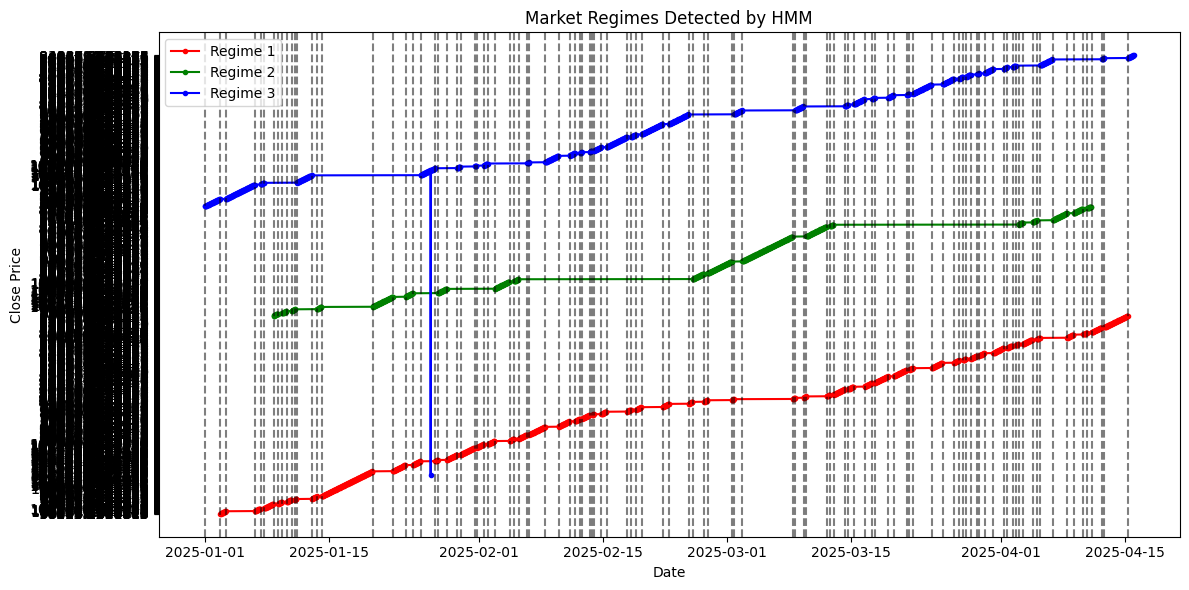

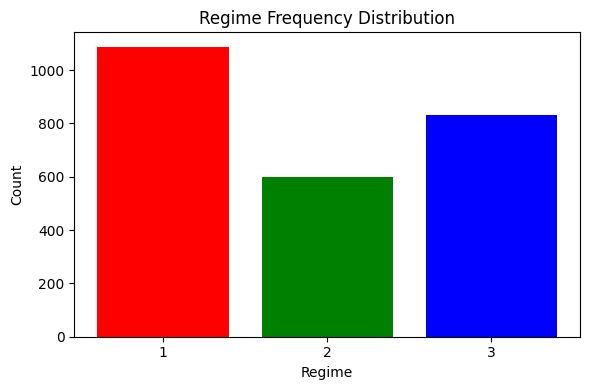

In [17]:
# --- Step 7: Apply Smoothing to Reduce Noise in Regime Changes ---
def rolling_mode(series, window=7):
    def safe_mode(x):
        m = mode(x, keepdims=True)
        return m.mode[0] if len(m.mode) > 0 else x.iloc[-1]
    # FIX: Use strictly forward-looking rolling (center=False)
    return series.rolling(window, center=False).apply(safe_mode, raw=False)

df["regime_smoothed"] = rolling_mode(df["regime"], window=7).ffill().bfill().astype(int)

# --- Step 8: Mark Major Regime Change Points ---
# FIX: Remove lookahead by not using shift(-15)
df["regime_change"] = df["regime_smoothed"].diff().ne(0).astype(int)
# (Optional alternative: If you prefer to confirm a change after 15 days, you could delay labeling:
# df["regime_change"] = df["regime_smoothed"].diff().ne(0).shift(15).fillna(0).astype(int))

# --- Step 9: Creating Regime-Based Features ---
# To avoid mixing non-contiguous periods with the same regime label, we create a block id:
df["block_id"] = df["regime_smoothed"].ne(df["regime_smoothed"].shift()).cumsum()

def regime_sma(df, column, window):
    # Compute rolling average within each contiguous block only
    return df.groupby("block_id")[column].apply(lambda x: x.rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)

# Apply Regime-Based Features
df["SMA_50_regime"] = regime_sma(df, "close", 50)
df["SMA_200_regime"] = regime_sma(df, "close", 200)
df["volatility_10_regime"] = regime_sma(df, "volatility_10", 10)
df["RSI_14_regime"] = regime_sma(df, "RSI_14", 14)

df.dropna(inplace=True)  # Drop rows with missing values

# --- Step 10: Fixing Regime Mapping and Visualization ---
# Remap 0,1,2 → 1,2,3 for consistent labeling
df["regime_smoothed"] = df["regime_smoothed"].map({0: 1, 1: 2, 2: 3})

# Define color mapping and labels for visualization
regime_colors = {1: "red", 2: "green", 3: "blue"}
regime_labels = {1: "Regime 1", 2: "Regime 2", 3: "Regime 3"}

plt.figure(figsize=(12, 6))
# Plot regime-based adjusted close prices
for regime, color in regime_colors.items():
    plt.plot(df[df["regime_smoothed"] == regime].index,
             df[df["regime_smoothed"] == regime]["close"],
             linestyle='-', marker='.', label=regime_labels[regime], color=color)
# Highlight regime change points
for change_date in df[df["regime_change"] == 1].index:
    plt.axvline(change_date, color='black', linestyle="--", alpha=0.5)
plt.title("Market Regimes Detected by HMM")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.savefig("1_regime_change_plot.png", dpi=100)
plt.show()

# --- Step 11: Fixed Regime Frequency Distribution ---
plt.figure(figsize=(6, 4))
regime_counts = df["regime_smoothed"].value_counts().sort_index()
bars = plt.bar(regime_counts.index, regime_counts.values, color=[regime_colors[i] for i in regime_counts.index])
plt.xticks(ticks=regime_counts.index, labels=regime_counts.index)
plt.title("Regime Frequency Distribution")
plt.xlabel("Regime")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("2_regime_frequency_distribution.png", dpi=300)
plt.show()

In [18]:
# --- Step 1: Ensure "regime_smoothed" Exists  ---
if "regime_smoothed" not in df.columns:
    print("Warning: 'regime_smoothed' column is missing! Recreating it...")
    if "regime" in df.columns:
        df["regime_smoothed"] = df["regime"].astype(int)
    else:
        raise KeyError("Error: Neither 'regime_smoothed' nor 'regime' found in DataFrame!")

# --- Step 2: Drop Any Old One-Hot Encoded Regime Columns (But NOT "regime_smoothed") ---
old_regime_cols = [col for col in df.columns if col.startswith("regime_") and col != "regime_smoothed"]
if old_regime_cols:
    df.drop(columns=old_regime_cols, inplace=True, errors="ignore")
    
# Preserve "regime_smoothed" before encoding to prevent KeyErrors
df["regime_smoothed_backup"] = df["regime_smoothed"]

# --- Step 3: One-Hot Encode Regimes for LSTM Training ---
df = pd.get_dummies(df, columns=["regime_smoothed"], prefix="regime")

# Ensure All Expected Regime Columns Exist (Fixes Missing regime_1)
expected_regimes = ["regime_1", "regime_2", "regime_3"]
for col in expected_regimes:
    if col not in df.columns:
        df[col] = 0  # Add missing regime column and fill with 0s

if "regime_smoothed" not in df.columns:
    df["regime_smoothed"] = df["regime_smoothed_backup"]
    
df.drop(columns=["regime_smoothed_backup"], inplace=True, errors="ignore")

# --- Step 4: Convert One-Hot Encoded Values to Integers ---
df[expected_regimes] = df[expected_regimes].astype(int)

# --- Step 5: Verify the Fix ---
display(df.tail())  # Check if columns are correct

print("Regime counts in dataset:")
print(df[expected_regimes].sum())  # Count number of rows for each regime

,close,high,low,open,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,EMA_200,...,regime,block_id,SMA_50_regime,SMA_200_regime,volatility_10_regime,RSI_14_regime,regime_1,regime_2,regime_3,regime_smoothed
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-15 19:00:00+00:00,84010.5234375,84194.7265625,83923.1328125,84192.203125,201334784,-0.0021819609539936464,0.0024599935266276214,-0.8869783315994628,84795.2918596058,83250.8102592913,...,2.0,107,85149.250000,85149.250000,0.002640,55.150838,0,0,1,3
2025-04-15 20:00:00+00:00,83947.0703125,84184.0703125,83828.2109375,84000.375,0,-0.0007555851045743688,0.0024355682324217983,-0.31022949573580844,84762.02826952323,83257.73822001976,...,2.0,107,85056.774639,85056.774639,0.002660,52.958093,0,0,1,3
2025-04-15 21:00:00+00:00,84188.2578125,84203.8984375,83893.625,84005.515625,0,0.0028689707050150158,0.002863902796721895,1.0017695811111054,84739.52746728703,83266.99712143748,...,2.0,107,84994.737723,84994.737723,0.002720,50.990640,0,0,1,3
2025-04-15 22:00:00+00:00,83793.53125,84181.140625,83702.3359375,84181.140625,0,-0.004699643827088361,0.00260407508634509,-1.804726696143188,84702.42957641302,83272.23626699531,...,2.0,107,84914.657292,84914.657292,0.002748,47.441956,0,0,1,3
2025-04-15 23:00:00+00:00,83628.125,83833.9375,83606.3515625,83833.9375,1123444736,-0.0019759248298084164,0.0025914032517183596,-0.7624922244340708,84660.29998518115,83275.77744841824,...,2.0,107,84834.249023,84834.249023,0.002777,43.227866,0,0,1,3


Regime counts in dataset:
regime_1    1087
regime_2     600
regime_3     831
dtype: int64


In [19]:
# Generate lag features (up to 7 days)
lags = 7
for lag in range(1, lags + 1):
    df[f'lag_{lag}'] = df['log_returns'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)

# Check DataFrame structure after adding lag features 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2025-01-01 08:00:00+00:00 to 2025-04-15 23:00:00+00:00
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   close                 2511 non-null   object 
 1   high                  2511 non-null   object 
 2   low                   2511 non-null   object 
 3   open                  2511 non-null   object 
 4   volume                2511 non-null   object 
 5   log_returns           2511 non-null   object 
 6   volatility_10         2511 non-null   object 
 7   vol_adj_returns       2511 non-null   object 
 8   EMA_50                2511 non-null   object 
 9   EMA_200               2511 non-null   object 
 10  RSI_14                2511 non-null   object 
 11  MACD                  2511 non-null   object 
 12  MACD_Signal           2511 non-null   object 
 13  ATR_14                2511 non-null   object 
 14  SAR                   25

In [21]:
# --- Step 6: Export to CSV ---
output_path = r"C:\\Users\\riche\\OneDrive\\Documents\\UMH25\\Output\\BTC_regime_processed.csv"
df.to_csv(output_path)
print(f"DataFrame exported successfully to: {output_path}")

DataFrame exported successfully to: C:\\Users\\riche\\OneDrive\\Documents\\UMH25\\Output\\BTC_regime_processed.csv
